### Let's begin with the imports.

In [1]:
import sqlite3 as sql
import csv
import os
import stat
import os.path
import glob

from collections import Counter
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil

from time import gmtime, strftime

# The two lines below allow us to see all the columns without truncation.
# It allows us to see the dataset better.
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### 

### First of all I want to join the path and the files inside of the 'sample_data' folder.

In [2]:
def path_merger(file_directory_path):
    '''
    This function merges the 'file_directory_path' path with the files inside of the folder.
    Returns the number of the files found in the directory.
    '''
    
    # We assign 'file_dir' variable to be string with the path to the sample data files.
    file_dir = file_directory_path
    
    # Merges the sample data folder path with the file name.
    file_list = [os.path.join(file_dir, file) for file in os.listdir(file_dir)]
    
    return file_list

In [3]:
try:
    file_list = path_merger('./sample_data/')
except FileNotFoundError as err:
    print('FileNotFoundError: [WinError 3] The system cannot find the specified path. Please try again.')

### We can see the result of the function 'path_merger'  in the sliced variable 'file_list' below. 

In [4]:
file_list[:3]

['./sample_data/PN000001.SMRT',
 './sample_data/PN000002.SMRT',
 './sample_data/PN000003.SMRT']

In [5]:
len(file_list)

12

### Next we need to check if the files are complete. In other words we can check if the files have the both keywords ('HEADR' and 'TRAIL'). If the files have both of the keywords a copy of them is made in other folder.

### As an example we can see in the cell below the number of keywords each file has.
### For functionallity check I added a file called 'PN000012' without 'TRAIL' keyword and another file called 'PN000011' both of the files are copy of 'PN000010'.

In [6]:
# This cell is only as example
# This for loop is counting the 'keywords' in the files

counter_for_the_files = []

for i in range(len(file_list)):
    
    with open(file_list[i], 'r', encoding='utf-8') as file:
        key_words = ['HEADR', 'TRAIL']
        key_word_counter = 0
        for line in file:
            for word in key_words:
                if word in line:
                    key_word_counter += 1
        counter_for_the_files.append(str(i) + ' - ' + str(key_word_counter))
    
counter_for_the_files

['0 - 2',
 '1 - 2',
 '2 - 2',
 '3 - 2',
 '4 - 2',
 '5 - 2',
 '6 - 2',
 '7 - 2',
 '8 - 2',
 '9 - 2',
 '10 - 2',
 '11 - 1']

In [7]:
def function_that_finds_the_complete_files_and_saves_a_copy(list_of_files):
    '''
    This function finds the number of the files that have two 'keywords' (complete files) - 'HEADR' and 'TRAIL'.
    Furthermore, it will separate the files that passed the check in other folder.
    In that way we can work with complete files.
    '''
    
    counter_for_the_files = []
    
    # This for loop collects the number of the file that has both 'keywords'.
    for i in range(len(file_list)):
        
        with open(list_of_files[i], 'r', encoding='utf-8') as file:
            key_words = ['HEADR', 'TRAIL']
            key_word_counter = 0
            for line in file:
                for word in key_words:
                    if word in line:
                        key_word_counter += 1
                        
                if key_word_counter == 2:
                    counter_for_the_files.append(i)

                else:
                    pass
            
    counter_for_the_files
    
    
    # The only thing that we need to do manually is to create the folder, where we will store the files: 'pandas_data'
    # We copy the files that pass the initial test so we can remove the keywords

    for i in range(len(counter_for_the_files)):
        # If the file is  in the list, then it means that the file is complete and we do want to use it.
        if i in counter_for_the_files:
            shutil.copyfile(list_of_files[i], './pandas_data/' + str(list_of_files[i][14:22]) + '_copy.SMRT')
        # If the file doesn't have both of the keywords we want to remove them.
        else:
            pass
    return counter_for_the_files

In [8]:
function_that_finds_the_complete_files_and_saves_a_copy(file_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### As we can see the number of files is 11, which means that we have removed the one which is not complete.

### Next we use the function we defined earlier to join the path and the copied files that have passed the requirement.

In [9]:
# We assign 'pandas_file_dir' be string with the path to the copied sample data files.
try:
    pandas_file_dir = path_merger('./pandas_data/')
except FileNotFoundError as err:
    print('FileNotFoundError: [WinError 3] The system cannot find the specified path. Please try again.')

### We can start the cleaning process.
### The following code removes the keywords mentioned earlier, we can leave them in or remove them the cell below is optional.
### But we will not delete the main files, that will ruin the data that we collected. We need to save the new files in a new folder that will contain only data that is reliable and it can be loaded straight to 'Pandas' for additional work.

In [10]:
# CAN BE IGNORED
def key_words_cleaner(filtered_file_list):
    '''
    This function is optional it deletes the keywords of the copy we have saved.
    Opens to read all the files and replaces the items of the list with empty strings
    and saves it to empty list 'text' and then writes the contents of 'text' to the already read file.
    '''
    
    for i in range(len(filtered_file_list)):
        with open(filtered_file_list[i], 'r', encoding='utf-8') as file:
            key_words = ['HEADR', 'TRAIL']
            text = []
            for line in file:
                for word in key_words:
                    line = line.replace(word, '')
                text.append(line)
        with open(filtered_file_list[i], 'w+', encoding='utf-8') as file:
            for line in text:
                file.write(line)

In [11]:
key_words_cleaner(pandas_file_dir)

### Now we can proceed with the editing using Pandas.

In [12]:
def preliminary_pandas_editor(filtered_file_list):
    '''
    This function does initial preparation for the data.
    '''
       
    for i in range(len(filtered_file_list)):
        
        # We can skip the footer, because it is full of 'NaN'-s, clear the header.
        dataframe = pd.read_csv(filtered_file_list[i], skipfooter = 1, header = None, engine = 'python')
        
        # Give proper names to the columns.
        dataframe.columns = ['record_identifier', 'meter_number', 'measurement_date', 'measurement_time', 'consumption', 'table_info'] 
        
        # Creating new columns with information taken from the first 'HEADR' row.
        dataframe[['file_type_identifier']] = str(dataframe['meter_number'].iloc[0])
        dataframe[['company_id']] = str(dataframe['measurement_date'].iloc[0])
        dataframe[['file_creation_date']] = str(dataframe['measurement_time'].iloc[0])
        dataframe[['file_creation_time']] = str(dataframe['consumption'].iloc[0])[:-2]
        dataframe[['file_generation_number']] = str(dataframe['table_info'].iloc[0])
        
        dataframe['measurement_time'] = dataframe['measurement_time'].astype(object)
        dataframe['measurement_date'] = dataframe['measurement_date'].astype(object)
        dataframe['file_creation_date'] = dataframe['file_creation_date'].astype(object)
        dataframe['file_creation_time'] = dataframe['file_creation_time'].astype(object)
        
        # We can delete the first row because we got the info from it assigned to new columns.
        dataframe.drop(labels = 0, axis = 0, inplace = True)
        
        # We can delete this column, it is empty and we don't need it.
        dataframe.drop(['table_info'], axis = 1, inplace = True)
        
        dataframe.to_csv(filtered_file_list[i], encoding='utf-8')
        

In [13]:
preliminary_pandas_editor(pandas_file_dir)

### We can see an example of what we have done so far.

In [14]:
test_1 = pd.read_csv(pandas_file_dir[0], index_col = 'Unnamed: 0')

In [15]:
test_1.head()

record_identifier  meter_number  measurement_date  measurement_time  \
1             CONSU             2          20191014              1100   
2             CONSU             2          20191014              1200   
3             CONSU             2          20191014              1300   
4             CONSU             2          20191014              1400   
5             CONSU             2          20191014              1500   

   consumption file_type_identifier company_id  file_creation_date  \
1        10.28                 SMRT        GAZ            20191016   
2         2.84                 SMRT        GAZ            20191016   
3        14.65                 SMRT        GAZ            20191016   
4        11.69                 SMRT        GAZ            20191016   
5        14.02                 SMRT        GAZ            20191016   

   file_creation_time file_generation_number  
1              102939               PN000001  
2              102939               PN000001  
3              102939               PN000001  
4              102939               PN000001  
5              102939               PN000001

### The function earlier that made a copy of the files might have copied files with the same name. The following code removed any repetition.

### The cell below shows an example, where we have copy of 'PN000010'.

In [16]:
list_for_checking_repeating = []

for i in range(len(pandas_file_dir)):
    dataframe = pd.read_csv(pandas_file_dir[i], index_col = 'Unnamed: 0')
    list_for_checking_repeating.append(dataframe['file_generation_number'].iloc[0])

list_for_checking_repeating

['PN000001',
 'PN000002',
 'PN000003',
 'PN000004',
 'PN000005',
 'PN000006',
 'PN000007',
 'PN000008',
 'PN000009',
 'PN000010',
 'PN000010']

In [17]:
def repetition_remover(filtered_file_list):
    '''
    Removes the duplicate files from the copy folder.
    '''
    
    # As per the cell above this list variable stores all the files in the copy folder.
    list_for_checking_repeating = []
    
    # 'new list' is used to store the new list without repetitions.
    new_list = []
    
    # We fill the list with the file names.
    for i in range(len(pandas_file_dir)):
        dataframe = pd.read_csv(pandas_file_dir[i], index_col = 'Unnamed: 0')
        list_for_checking_repeating.append(dataframe['file_generation_number'].iloc[0])

    
    # Search for the name of the repeating file.
    repeat = [item for item, count in Counter(list_for_checking_repeating).items() if count > 1]   
    
    repeating_files = []
    # Searching for the number of the repeating file in the folder.
    for i in range(len(pandas_file_dir)):
        dataframe = pd.read_csv(pandas_file_dir[i], index_col = 'Unnamed: 0')
        if dataframe['file_generation_number'].iloc[0] == repeat[0]:
            repeating_files.append(i)
    
    os.remove(pandas_file_dir[repeating_files[1]])
    
    
    
    return repeating_files, repeat[0]
    
    

In [18]:
repetition_remover(pandas_file_dir)

([9, 10], 'PN000010')

### After deleting the repeating file we need to refresh the variable 'pandas_file_dir'.

In [19]:
# We assign 'pandas_file_dir' be string with the path to the copied sample data files.
try:
    pandas_file_dir = path_merger('./pandas_data/')
except FileNotFoundError as err:
    print('FileNotFoundError: [WinError 3] The system cannot find the specified path. Please try again.')

In [20]:
len(pandas_file_dir)

10

### The file with repeating data was successfully removed. If we run the whole program and open at the same time the folder 'pandas_data' we can see the whole process happening infront of us.

# 

### The next step we can do is to convert the date and time columns to datetime column.

In [21]:
def columns_to_dateframe_column(filtered_file_list, date_column, time_column, new_column_name):
    '''
    !!! WARNING !!!
    Because this function modifies the dataframe, we must run it only once. If run twice error will appear.
    
    This function converts 'time' and 'date' columns from a 'dataframe' to a new 'datetime' column.
    Depending on the needs we might have to remove the initial 'date_column' and 'time_column', which
    will be replaced by 'new_column_name'.
    '''   
    
    for i in range(len(filtered_file_list)):
        # We can skip the footer, because it is full of 'NaN'-s, clear the header.
        dataframe = pd.read_csv(filtered_file_list[i], index_col = 'Unnamed: 0')
    
        #'SettingWithCopyWarning' warning pops up and tells us that 'A value is trying to be set on a copy of a 
        #       slice from a DataFrame'.
        # We can ignore this warning, because we have the main data in other folder. 
        # The first line below deactivates 'SettingWithCopyWarning', which is not useful in our case.

        pd.set_option('mode.chained_assignment', None)


        # Adds zeros to reach the proper number of values.
        for j in range(len(dataframe)):
            if len(str(dataframe[time_column].iloc[j])) == 1:
                 dataframe[time_column].iloc[j] = '000' + str(dataframe[time_column].iloc[j]) + '00'
            elif len(str(dataframe[time_column].iloc[j])) == 2:
                dataframe[time_column].iloc[j] = '00' + str(dataframe[time_column].iloc[j]) + '00'
            elif len(str(dataframe[time_column].iloc[j])) == 3:
                dataframe[time_column].iloc[j] = '0' + str(dataframe[time_column].iloc[j]) + '00'
            elif len(str(dataframe[time_column].iloc[j])) == 4:
                dataframe[time_column].iloc[j] = str(dataframe[time_column].iloc[j]) + '00'


        # Adding ':' and '/' to match the time format.
        for k in range(len(dataframe)):
            dataframe[date_column].iloc[k] = str(dataframe[date_column].iloc[k])[:4] + '/' + str(dataframe[date_column].iloc[k])[4:6] + '/' + str(dataframe[date_column].iloc[k])[6:8]
            dataframe[time_column].iloc[k] = str(dataframe[time_column].iloc[k])[:2] + ':' + str(dataframe[time_column].iloc[k])[2:4] + ':' + str(dataframe[time_column].iloc[k])[4:6]


        # Creating new column for the datetime.
        dataframe[new_column_name] = dataframe[date_column] + ' ' + dataframe[time_column]


        # Converting the newly create column to datetime.
        pd.to_datetime(dataframe[new_column_name])


        # We might want to remove the 'date_column' and 'time_column' we used to create the 'datetime column'.
        # On the other hand if we want to leave them in we can comment out the lines below.
        dataframe.drop([date_column, time_column], axis = 1, inplace = True)
        
        dataframe.to_csv(filtered_file_list[i], encoding='utf-8')

#    return dataframe.head()

In [22]:
# Applying the changes to all of the files
columns_to_dateframe_column(pandas_file_dir, 'measurement_date', 'measurement_time', 'measurement_datetime')
columns_to_dateframe_column(pandas_file_dir, 'file_creation_date', 'file_creation_time', 'file_creation_datetime')

### Let's see an example of the work we have done so far.

In [23]:
test_2 = pd.read_csv(pandas_file_dir[0], index_col = 'Unnamed: 0')

In [24]:
test_2.head()

record_identifier  meter_number  consumption file_type_identifier  \
1             CONSU             2        10.28                 SMRT   
2             CONSU             2         2.84                 SMRT   
3             CONSU             2        14.65                 SMRT   
4             CONSU             2        11.69                 SMRT   
5             CONSU             2        14.02                 SMRT   

  company_id file_generation_number measurement_datetime  \
1        GAZ               PN000001  2019/10/14 11:00:00   
2        GAZ               PN000001  2019/10/14 12:00:00   
3        GAZ               PN000001  2019/10/14 13:00:00   
4        GAZ               PN000001  2019/10/14 14:00:00   
5        GAZ               PN000001  2019/10/14 15:00:00   

  file_creation_datetime  
1    2019/10/16 10:29:39  
2    2019/10/16 10:29:39  
3    2019/10/16 10:29:39  
4    2019/10/16 10:29:39  
5    2019/10/16 10:29:39

### We can see that some of the information in the columns remains the same. But I prefer to leave it like that.

### Next we can combine all the files from the 'pandas_data' folder. To make that file unique to the we can see that the file name has appended the file creation time.

In [25]:
# Combining the files.

# Empty list.
df_list = []

for i in range(len(pandas_file_dir)):
    dataframe = pd.read_csv(pandas_file_dir[i], index_col = 'Unnamed: 0')
    df_list.append(dataframe)
    
combined_dataframe = pd.concat(df_list, axis = 0)

combined_dataframe.to_csv('combined_dataframe_' + str(strftime("%Y-%m-%d_%H:%M:%S", gmtime())).replace(':','.') + '.csv')

### We can check in the main folder to see the name of the combined dataframe.

### Now there are columns with data that is constant, but it might be useful to let it stay. After all it is not hard to delete columns or to combine the content of the all of the constant columns and combine it into one. For now I am happy with the result.

### 
### SQLite3

In [26]:
# Creates SQL table from the combined *.CSV file

# Instantiate new table
con = sql.connect('./gas_metering_data.db')
cur = con.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS gas_table (record_identifier, meter_number, consumption, file_type_identifier, company_id, file_generation_number, measurement_datetime, file_creation_datetime);") # use your column names here


with open('combined_dataframe_2021-09-12_07.07.13.csv', 'r') as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['record_identifier'],
              i['meter_number'], 
              i['consumption'],
              i['file_type_identifier'],
              i['company_id'],
              i['file_generation_number'],
              i['measurement_datetime'],
              i['file_creation_datetime']) for i in dr]



cur.executemany("INSERT INTO gas_table (record_identifier, meter_number, consumption, file_type_identifier, company_id, file_generation_number, measurement_datetime, file_creation_datetime) VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
con.commit()
con.close()

### The above cell creates SQLite3 table. It works and can be viewed online. 
### Below you can see how I tried to amend the write/read options of the file/folder. I used to get:
### OperationalError: unable to open database file.

In [27]:
os.chmod('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db', 0o664)

In [28]:
os.chmod(
    'C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
    stat.S_IRUSR |
    stat.S_IWUSR |
    stat.S_IXUSR |
    stat.S_IRGRP |
    stat.S_IWGRP |
    stat.S_IXGRP |
    stat.S_IROTH |
    stat.S_IWOTH |
    stat.S_IXOTH |
    stat.S_IEXEC |
    stat.S_IRWXU |
    stat.S_IRWXG |
    stat.S_IRWXO |
    stat.S_IREAD |
    stat.S_IWRITE)


# S_IRUSR  (00400)  read by owner
# S_IWUSR  (00200)  write by owner
# S_IXUSR  (00100)  execute/search by owner
# S_IRGRP  (00040)  read by group
# S_IWGRP  (00020)  write by group
# S_IXGRP  (00010)  execute/search by group
# S_IROTH  (00004)  read by others
# S_IWOTH  (00002)  write by others
# S_IXOTH  (000
# stat.S_ISUID : Set user ID on execution
# stat.S_ISGID : Set group ID on execution
# stat.S_ENFMT : Record locking enforced
# stat.S_ISVTX : Save text image after execution
# stat.S_IREAD : Read by owner.
# stat.S_IWRITE : Write by owner.
# stat.S_IEXEC : Execute by owner.
# stat.S_IRWXU : Read, write, and execute by owner
# stat.S_IRUSR : Read by owner
# stat.S_IWUSR : Write by owner.
# stat.S_IXUSR : Execute by owner.
# stat.S_IRWXG : Read, write, and execute by group
# stat.S_IRGRP : Read by group
# stat.S_IWGRP : Write by group
# stat.S_IXGRP : Execute by group
# stat.S_IRWXO : Read, write, and execute by others.
# stat.S_IROTH : Read by others
# stat.S_IWOTH : Write by others
# stat.S_IXOTH : Execute by others

### This is the actual SQL query.

In [29]:
# SQL query

conn = sql.connect('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db')
gas_metering_data = pd.read_sql('SELECT * FROM gas_table', conn)

gas_metering_data.head()

record_identifier meter_number consumption file_type_identifier company_id  \
0             CONSU            2       10.28                 SMRT        GAZ   
1             CONSU            2        2.84                 SMRT        GAZ   
2             CONSU            2       14.65                 SMRT        GAZ   
3             CONSU            2       11.69                 SMRT        GAZ   
4             CONSU            2       14.02                 SMRT        GAZ   

  file_generation_number measurement_datetime file_creation_datetime  
0               PN000001  2019/10/14 11:00:00    2019/10/16 10:29:39  
1               PN000001  2019/10/14 12:00:00    2019/10/16 10:29:39  
2               PN000001  2019/10/14 13:00:00    2019/10/16 10:29:39  
3               PN000001  2019/10/14 14:00:00    2019/10/16 10:29:39  
4               PN000001  2019/10/14 15:00:00    2019/10/16 10:29:39

In [30]:
def sql_query(database_path, query):
    '''
    This function does SQL queries.
    '''
   
    conn = sql.connect(database_path)
    gas_metering_data = pd.read_sql(query, conn)
    return gas_metering_data

### 

### Below you can see example queries.

In [31]:
# 1. How many meters are in the dataset?
# -- SELECT COUNT ( DISTINCT meter_number ) FROM gas_table;

sql_query('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
          'SELECT COUNT ( DISTINCT meter_number ) FROM gas_table')

COUNT ( DISTINCT meter_number )
0                               10

In [32]:
# -- 2. What is all the data for a given meter?
# -- SELECT * FROM gas_table WHERE meter_number = '9';

meter_9_data = sql_query('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
          'SELECT * FROM gas_table WHERE meter_number = "9"')

meter_9_data.head()

record_identifier meter_number consumption file_type_identifier company_id  \
0             CONSU            9       15.43                 SMRT        GAZ   
1             CONSU            9        9.08                 SMRT        GAZ   
2             CONSU            9        4.69                 SMRT        GAZ   
3             CONSU            9        6.24                 SMRT        GAZ   
4             CONSU            9       11.89                 SMRT        GAZ   

  file_generation_number measurement_datetime file_creation_datetime  
0               PN000005  2019/10/15 13:00:00    2019/10/16 10:29:44  
1               PN000005  2019/10/15 14:00:00    2019/10/16 10:29:44  
2               PN000005  2019/10/15 15:00:00    2019/10/16 10:29:44  
3               PN000005  2019/10/15 16:00:00    2019/10/16 10:29:44  
4               PN000005  2019/10/15 17:00:00    2019/10/16 10:29:44

In [33]:
# -- 3. How many files have we recieved?
# -- SELECT COUNT ( DISTINCT file_generation_number ) FROM gas_table;

sql_query('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
          'SELECT COUNT ( DISTINCT file_generation_number ) FROM gas_table')

COUNT ( DISTINCT file_generation_number )
0                                         10

In [34]:
#  -- 4. What was the last file to be recieved?
# -- SELECT file_generation_number FROM gas_table ORDER BY file_generation_number DESC LIMIT 1;

sql_query('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
          'SELECT file_generation_number FROM gas_table ORDER BY file_generation_number DESC LIMIT 1')

file_generation_number
0               PN000010

In [35]:
# -- 5. Gas consumption for one meter for a day?
# -- SELECT measurement_datetime, consumption
# -- FROM gas_table 
# -- WHERE measurement_datetime BETWEEN "2019/10/14 11:00:00" 
# -- AND "2019/10/14 23:00:00" AND meter_number = "7";

meter_7_consumption = sql_query('C:/Users/Jessica/Desktop/- Mladen Tsolov - GazpromEnergyDataEngineerCodeTest/gas_metering_data.db',
          'SELECT measurement_datetime, consumption FROM gas_table WHERE measurement_datetime BETWEEN "2019/10/14 11:00:00" AND "2019/10/14 23:00:00" AND meter_number = "7"')
meter_7_consumption.head()

measurement_datetime consumption
0  2019/10/14 11:00:00       12.01
1  2019/10/14 12:00:00        5.74
2  2019/10/14 13:00:00       19.36
3  2019/10/14 14:00:00        6.59
4  2019/10/14 15:00:00        3.86

In [36]:
meter_7_consumption.index = meter_7_consumption.index.astype(np.int64)
meter_7_consumption.consumption = meter_7_consumption.consumption.astype(np.float64)

meter_7_consumption.dtypes

measurement_datetime     object
consumption             float64
dtype: object

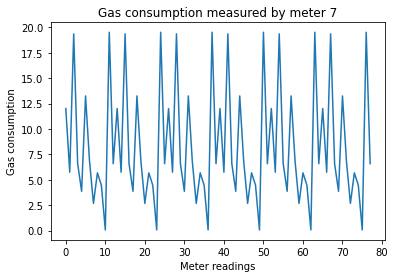

In [37]:
plt.plot(meter_7_consumption.index, meter_7_consumption.consumption)

plt.title('Gas consumption measured by meter 7')
plt.xlabel('Meter readings')
plt.ylabel('Gas consumption')

plt.show()

### Below you can see a sample function that creates a table. 

In [38]:
def create_new_sql_table(csv_file_name, database_file_name):
    
    try:
        sql_query_dataframe = pd.read_csv(csv_file_name, index_col = 'Unnamed: 0')
    
        conn = sql.connect(database_file_name + '.db')

        sql_query_dataframe.to_sql(csv_file_name, conn)
        
        return (f'{database_file_name}.db created successfully.')
    
    
    except FileNotFoundError:
        return ('FileNotFoundError: [WinError 3] The system cannot find the specified path. Please try again.')
    
    except ValueError:
        return (f'ValueError: Table {database_file_name}.db already exists.')

### 

### The SQL queries can be done online as well. We can upload the database file to the URL and we can run the queries.

In [39]:
# https://extendsclass.com/sqlite-browser.html#

# -- Shows the complete table
# -- SELECT * FROM gas_table;

# -- 1. How many meters are in the dataset?
# -- SELECT COUNT ( DISTINCT meter_number ) FROM gas_table;

# -- 2. What is all the data for a given meter?
# -- SELECT * FROM gas_table WHERE meter_number = '9';

# -- 3. How many files have we recieved?
# -- SELECT COUNT ( DISTINCT file_generation_number ) FROM gas_table;

# -- 4. What was the last file to be recieved?
# -- SELECT file_generation_number FROM gas_table ORDER BY file_generation_number DESC LIMIT 1;

# -- 5. Gas consumption for one meter for a day?
# -- SELECT measurement_datetime, consumption
# -- FROM gas_table 
# -- WHERE measurement_datetime BETWEEN "2019/10/14 11:00:00" 
# -- AND "2019/10/14 23:00:00" AND meter_number = "7";

### References:

### https://docs.python.org/3/library/shutil.html
### https://stackoverflow.com/questions/123198/how-do-i-copy-a-file-in-python
### https://stackoverflow.com/questions/7356043/how-to-delete-specific-strings-from-a-file